# Metadata

```yaml
Course:    DS 5001
Module:    09 Lab
Topic:     Homework 9
Author:    Andrew Avitabile
Date:      27 March 2024
```

# Set Up

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
# Adjust this for a new corpus
data_prefix = 'austen-melville'
table_dir =  f'{data_home}/{data_prefix}'
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:4] # Paragraphs
SENT = OHCO[:5] # Sentences
BAG = PARA

In [3]:
# word2vec parameters
w2v_params_JA = dict(
    window = 2,
    vector_size = 256,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)
w2v_params_HM = dict(
    window = 2,
    vector_size = 256,
    min_count = 80, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [4]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE
import plotly_express as px

In [5]:
import gensim
gensim.__version__

'4.3.0'

# Import `TOKENS`, `VOCAB`, and `LIB`

We import data from the TOKEN table of the novels corpus, excluding proper nouns.

In [6]:
LIB = pd.read_csv(f'{output_dir}/{data_prefix}-LIB.csv')

In [7]:
TOKENS = pd.read_csv(f'{output_dir}/{data_prefix}-TOKEN.csv').set_index(OHCO)

In [8]:
VOCAB = pd.read_csv(f'{output_dir}/{data_prefix}-VOCAB.csv').set_index('term_str')
VOCAB

n  n_chars             p          i max_pos max_pos_group  \
term_str                                                               
0          2        1  1.031073e-06  19.887422      CD            CD   
1         22        1  1.134180e-05  16.427991      CD            CD   
10         5        2  2.577682e-06  18.565494      CD            CD   
100        2        3  1.031073e-06  19.887422      CD            CD   
1000       2        4  1.031073e-06  19.887422      CD            CD   
...       ..      ...           ...        ...     ...           ...   
æneas      1        5  5.155365e-07  20.887422      NN            NN   
æniad      1        5  5.155365e-07  20.887422      NN            NN   
æson       2        4  1.031073e-06  19.887422      NN            NN   
æsops      1        5  5.155365e-07  20.887422     NNS            NN   
ł20000     1        6  5.155365e-07  20.887422      NN            NN   

          n_pos_group cat_pos_group  n_pos              cat_pos  stop  \
term_str                                                                
0                   1        {'CD'}      1               {'CD'}     0   
1                   2  {'NN', 'CD'}      3  {'NN', 'NNP', 'CD'}     0   
10                  1        {'CD'}      1               {'CD'}     0   
100                 1        {'CD'}      1               {'CD'}     0   
1000                1        {'CD'}      1               {'CD'}     0   
...               ...           ...    ...                  ...   ...   
æneas               1        {'NN'}      1               {'NN'}     0   
æniad               1        {'NN'}      1               {'NN'}     0   
æson                1        {'NN'}      1               {'NN'}     0   
æsops               1        {'NN'}      1              {'NNS'}     0   
ł20000              1        {'NN'}      1               {'NN'}     0   

         stem_porter stem_snowball stem_lancaster  
term_str                                           
0                  0             0              0  
1                  1             1              1  
10                10            10             10  
100              100           100            100  
1000            1000          1000           1000  
...              ...           ...            ...  
æneas           ænea          ænea           ænea  
æniad          æniad         æniad          æniad  
æson            æson          æson           æson  
æsops           æsop          æsop           æsop  
ł20000        ł20000        ł20000         ł20000  

[39430 rows x 14 columns]

### Filter the TOKEN table to include only nouns and verbs, excluding proper nouns.

In [9]:
# Function to filter nouns and verbs, excluding proper nouns
def filter_nouns_verbs(df):
    filtered_df = df[df['pos'].apply(lambda x: x.startswith('N') or x.startswith('V'))]  # Filter nouns and verbs
    filtered_df = filtered_df[~filtered_df['pos'].str.startswith('NNP')]  # Exclude proper nouns
    return filtered_df

In [10]:
TOKENS_FILTERED = filter_nouns_verbs(TOKENS)

### Convert the TOKEN table into two Gensim co7rpora, one for each author.

In [11]:
LIB_CL = LIB[['book_id', 'author', 'title']]
LIB_CL['key'] = LIB['book_id'].astype(str) + ' - ' + LIB['title']
LIB_CL = LIB_CL.set_index('book_id')

C:\Users\Andre\AppData\Local\Temp\ipykernel_3236\556359191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LIB_CL['key'] = LIB['book_id'].astype(str) + ' - ' + LIB['title']


In [12]:
LIB_JA = LIB[LIB['author'] == 'AUSTEN, JANE']
LIB_HM = LIB[LIB['author'] == 'MELVILLE, HERMAN']

In [13]:
TOKENS_FILTERED_JA = TOKENS_FILTERED.reset_index().merge(LIB_JA.reset_index(), how='inner', on='book_id').set_index(OHCO)
TOKENS_FILTERED_HM = TOKENS_FILTERED.reset_index().merge(LIB_HM.reset_index(), how='inner', on='book_id').set_index(OHCO)

# Convert to Gensim

We now create a Gensim-style corpus of docs, a list of lists of tokens.

In [14]:
docs_JA = TOKENS_FILTERED_JA[~TOKENS_FILTERED_JA.pos.str.match('NNPS?')].dropna(subset='term_str')\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs_JA = [doc for doc in docs_JA if len(doc) > 1] # Lose single word docs

In [15]:
docs_HM = TOKENS_FILTERED_HM[~TOKENS_FILTERED_HM.pos.str.match('NNPS?')].dropna(subset='term_str')\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs_HM = [doc for doc in docs_HM if len(doc) > 1] # Lose single word docs

In [16]:
vocab_HM = Dictionary(docs_HM)
vocab_JA = Dictionary(docs_JA)

In [17]:
vocab_JA

# Generate word embeddings with Gensim's module

In [18]:
model_JA = word2vec.Word2Vec(docs_JA, **w2v_params_JA)
model_HM = word2vec.Word2Vec(docs_HM, **w2v_params_HM)

# For each corpus, extract a vocabulary table with the following features:
- n: the raw count of the tokens for the term in the corpus
- pos_group: the grouped maximum part-of-speech of the term (i.e. first get maximum POS, then group by first two characters)

In [19]:
TOKENS_FILTERED_JA

pos_tuple  pos  \
book_id chap_num para_num sent_num token_num                              
105     1        1        0        8                ('was', 'VBD')  VBD   
                                   10                ('man', 'NN')   NN   
                                   11               ('who,', 'NN')   NN   
                                   15         ('amusement,', 'NN')   NN   
                                   17              ('took', 'VBD')  VBD   
...                                                            ...  ...   
1342    61       15       1        28              ('been', 'VBN')  VBN   
                                   30             ('means', 'NNS')  NNS   
                                   32           ('uniting', 'VBG')  VBG   
                                   33              ('them.', 'NN')   NN   
                 18       0        0                 ('End', 'NN')   NN   

                                               token_str   term_str pos_group  \
book_id chap_num para_num sent_num token_num                                    
105     1        1        0        8                 was        was        VB   
                                   10                man        man        NN   
                                   11               who,        who        NN   
                                   15         amusement,  amusement        NN   
                                   17               took       took        VB   
...                                                  ...        ...       ...   
1342    61       15       1        28               been       been        VB   
                                   30              means      means        NN   
                                   32            uniting    uniting        VB   
                                   33              them.       them        NN   
                 18       0        0                 End        end        NN   

                                              index  \
book_id chap_num para_num sent_num token_num          
105     1        1        0        8              0   
                                   10             0   
                                   11             0   
                                   15             0   
                                   17             0   
...                                             ...   
1342    61       15       1        28             7   
                                   30             7   
                                   32             7   
                                   33             7   
                 18       0        0              7   

                                                                               source_file_path  \
book_id chap_num para_num sent_num token_num                                                      
105     1        1        0        8          C:/Users/Andre/OneDrive - University of Virgin...   
                                   10         C:/Users/Andre/OneDrive - University of Virgin...   
                                   11         C:/Users/Andre/OneDrive - University of Virgin...   
                                   15         C:/Users/Andre/OneDrive - University of Virgin...   
                                   17         C:/Users/Andre/OneDrive - University of Virgin...   
...                                                                                         ...   
1342    61       15       1        28         C:/Users/Andre/OneDrive - University of Virgin...   
                                   30         C:/Users/Andre/OneDrive - University of Virgin...   
                                   32         C:/Users/Andre/OneDrive - University of Virgin...   
                                   33         C:/Users/Andre/OneDrive - University of Virgin...   
                 18       0        0          C:/Users/Andre/OneDrive - University of Virgin...   

                       

In [20]:
# Define a function to calculate grouped maximum part-of-speech
def get_pos_group(pos_group):
    max_pos = pos_group.max()  # Get the maximum part-of-speech
    return max_pos[:2]  # Group by the first two characters

In [21]:
VOCAB_JA = TOKENS_FILTERED_JA.groupby(['term_str']).agg(n=('term_str', 'size'), pos_group=('pos', get_pos_group))
VOCAB_JA.reset_index(inplace=True)
VOCAB_JA = VOCAB_JA.set_index('term_str')

In [22]:
VOCAB_HM = TOKENS_FILTERED_HM.groupby(['term_str']).agg(n=('term_str', 'size'), pos_group=('pos', get_pos_group))
VOCAB_HM.reset_index(inplace=True)
VOCAB_HM = VOCAB_HM.set_index('term_str')

# Visualize with tSNE

In [23]:
VOCAB_JA['gsid'] = pd.DataFrame([i for i in vocab_JA.items()], columns=['gsid', 'term_str']).set_index('term_str')
VOCAB_JA = VOCAB_JA.dropna(subset='gsid').copy()
VOCAB_JA.gsid = VOCAB_JA.gsid.astype(int)

In [24]:
VOCAB_HM['gsid'] = pd.DataFrame([i for i in vocab_HM.items()], columns=['gsid', 'term_str']).set_index('term_str')
VOCAB_HM = VOCAB_HM.dropna(subset='gsid').copy()
VOCAB_HM.gsid = VOCAB_HM.gsid.astype(int)

In [25]:
def get_vector_JA(row):
    w = row.name
    try:
        vec = model_JA.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [26]:
WV_JA = pd.DataFrame(VOCAB_JA.apply(get_vector_JA, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [27]:
def get_vector_HM(row):
    w = row.name
    try:
        vec = model_HM.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [28]:
WV_HM = pd.DataFrame(VOCAB_JA.apply(get_vector_HM, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

## Use ScikitLearn's TSNE library

In [29]:
tsne_engine = TSNE(learning_rate=200, perplexity=20, n_components=2, init='random', n_iter=1000, random_state=42)

In [30]:
tsne_model_JA = tsne_engine.fit_transform(WV_JA.to_numpy())
tsne_model_HM = tsne_engine.fit_transform(WV_HM.to_numpy())

In [31]:
TSNE_JA = pd.DataFrame(tsne_model_JA, columns=['x','y'], index=WV_JA.index)
TSNE_HM = pd.DataFrame(tsne_model_HM, columns=['x','y'], index=WV_HM.index)

In [32]:
TSNE_JA_W_VOCAB = TSNE_JA.join(VOCAB_JA, how='left')
TSNE_HM_W_VOCAB = TSNE_HM.join(VOCAB_HM, how='left')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [33]:
def complete_analogy(model, A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

# Questions

1. Identify two regions of word clusters in the Austen plot that clearly contain words with associated meanings. Give a gloss of what you think these clusters "mean."

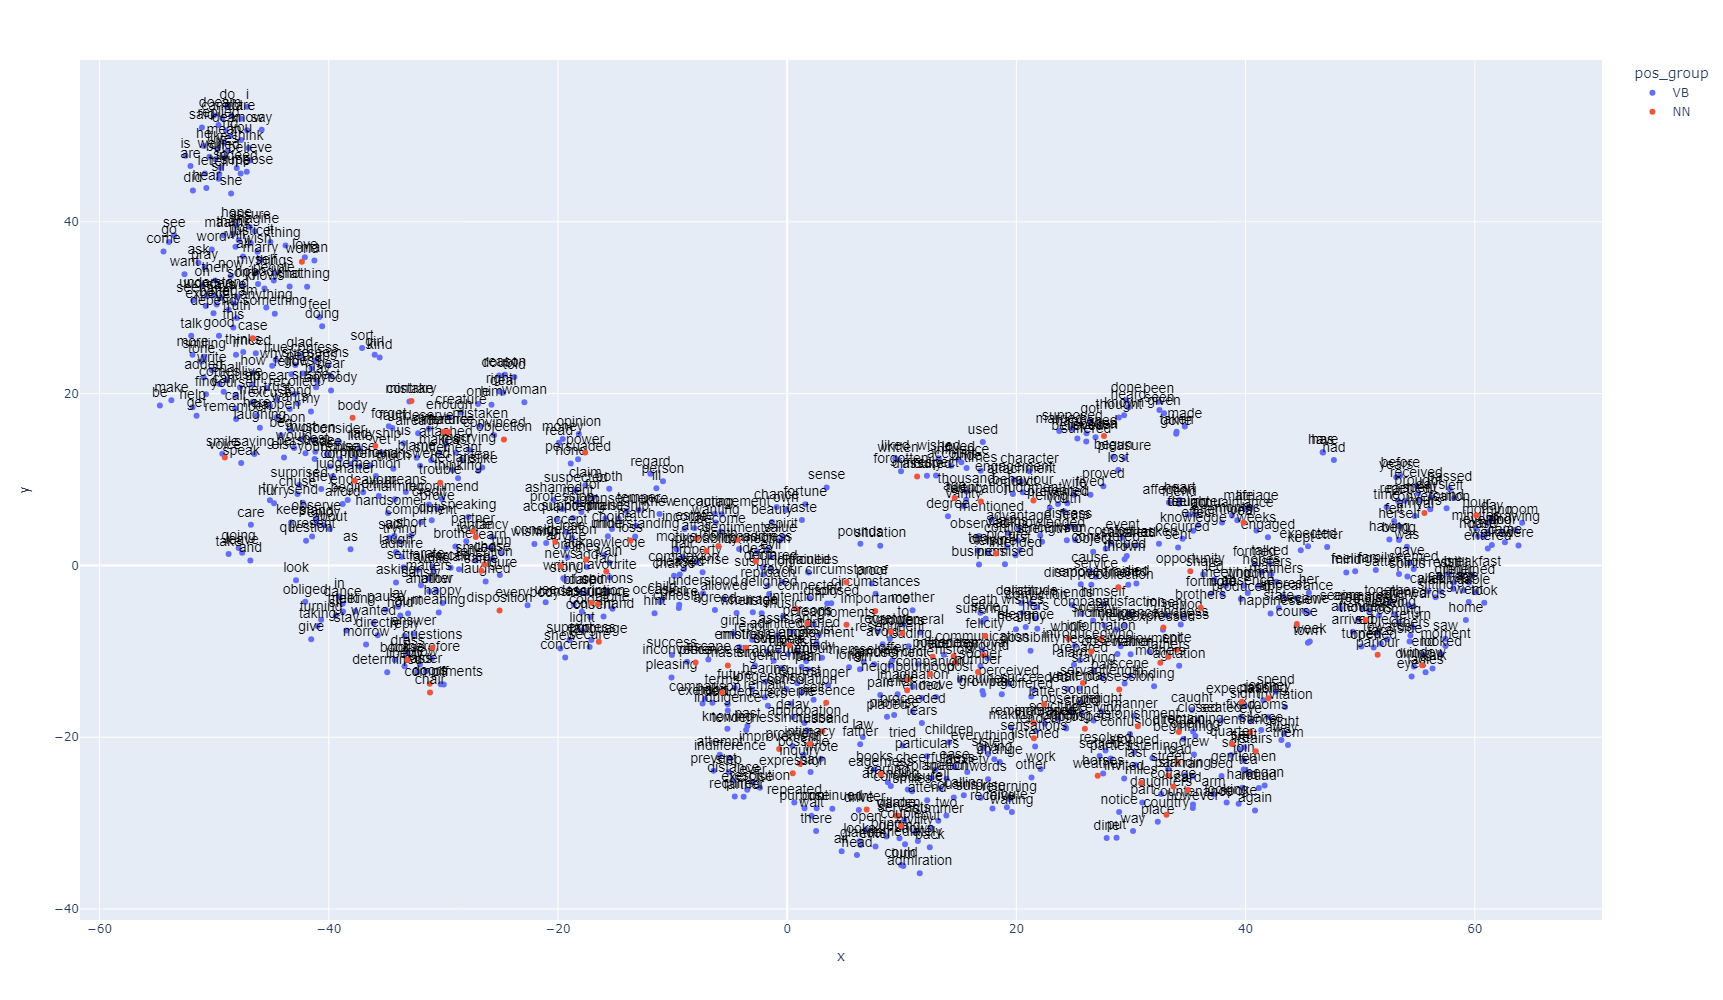

In [34]:
px.scatter(TSNE_JA_W_VOCAB.reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           height=1000).update_traces(
    mode='markers+text', 
    textfont=dict(color='black', size=14, family='Arial'),
    textposition='top center')

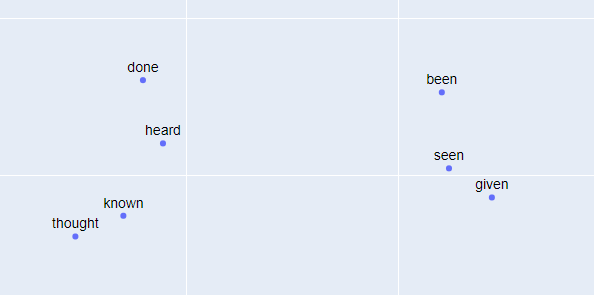

Verbs that you do to someone else?

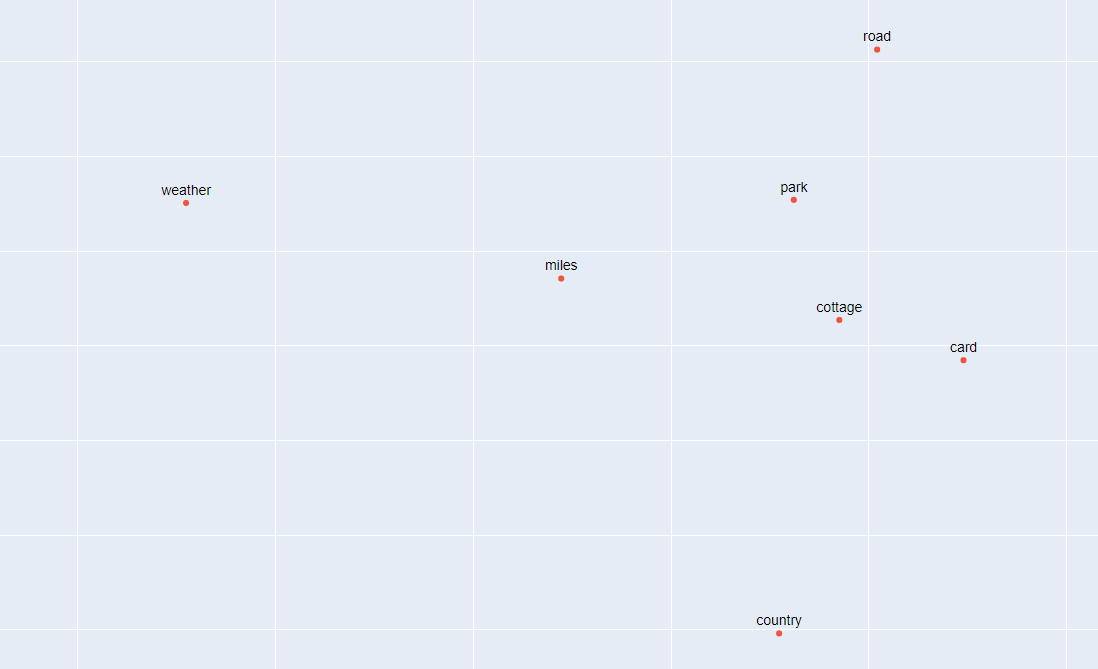

Rural places/things

2. Identify two regions of word clusters in the Melville plot that clearly contain words with associated meanings. Give a gloss of what you think these clusters "mean."

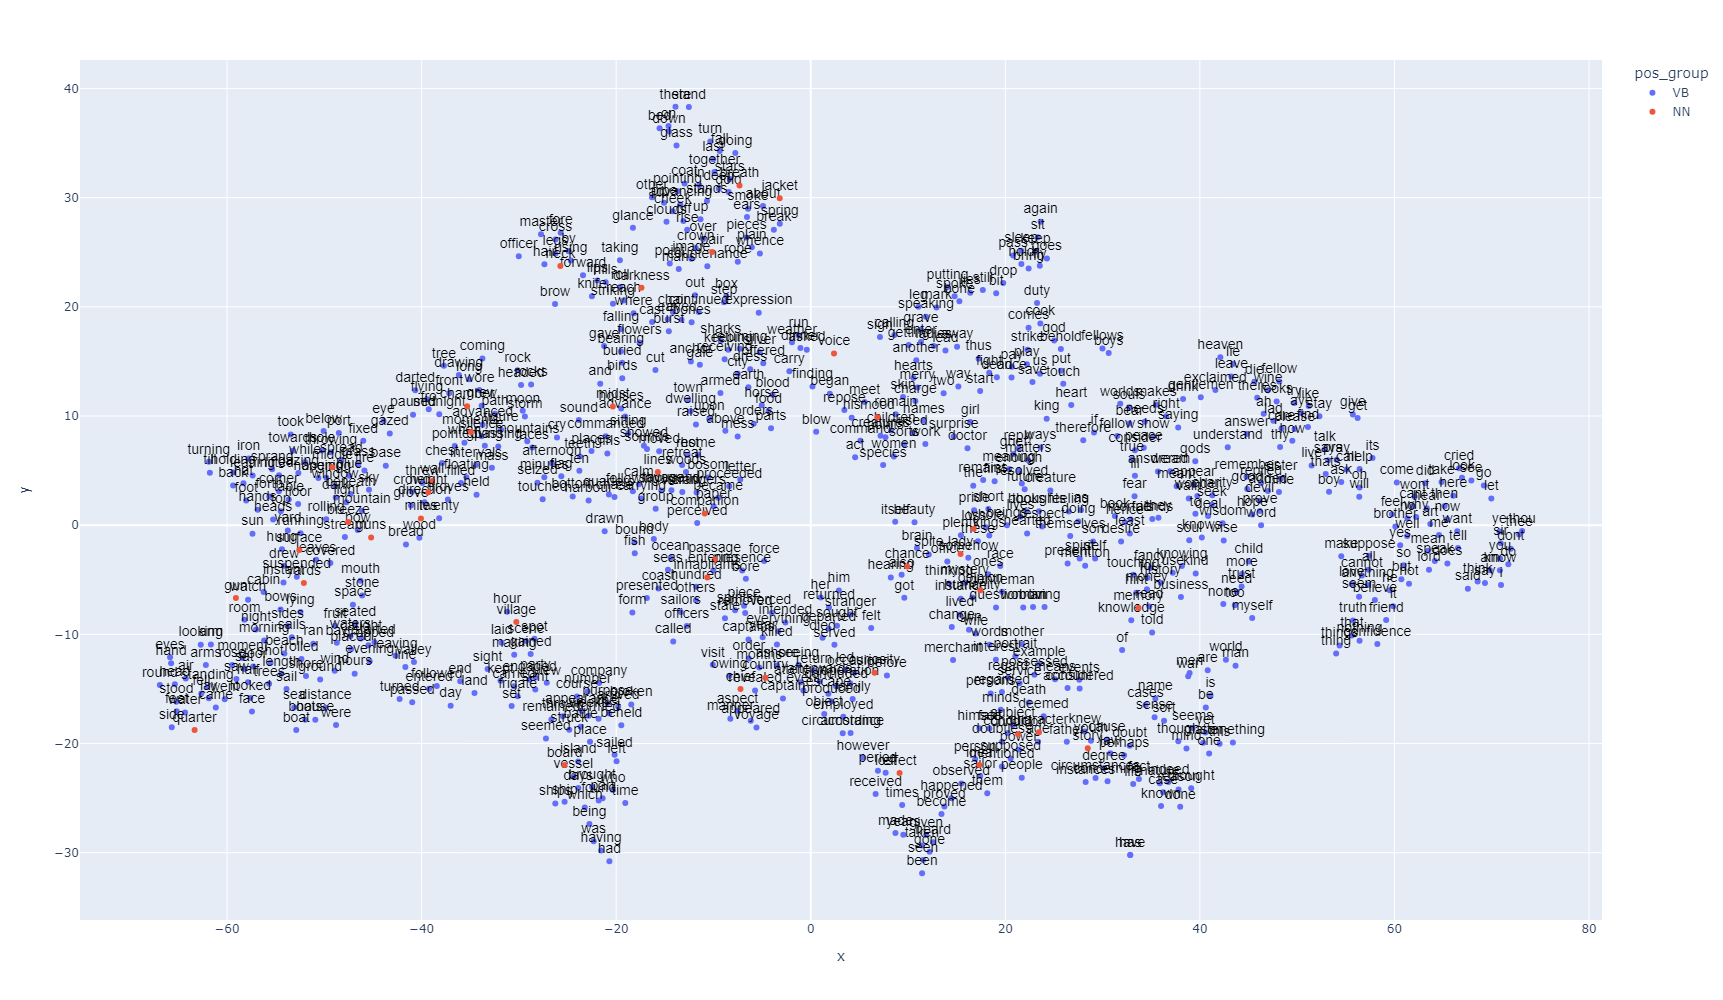

In [35]:
px.scatter(TSNE_HM_W_VOCAB.reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           height=1000).update_traces(
    mode='markers+text', 
    textfont=dict(color='black', size=14, family='Arial'),
    textposition='top center')

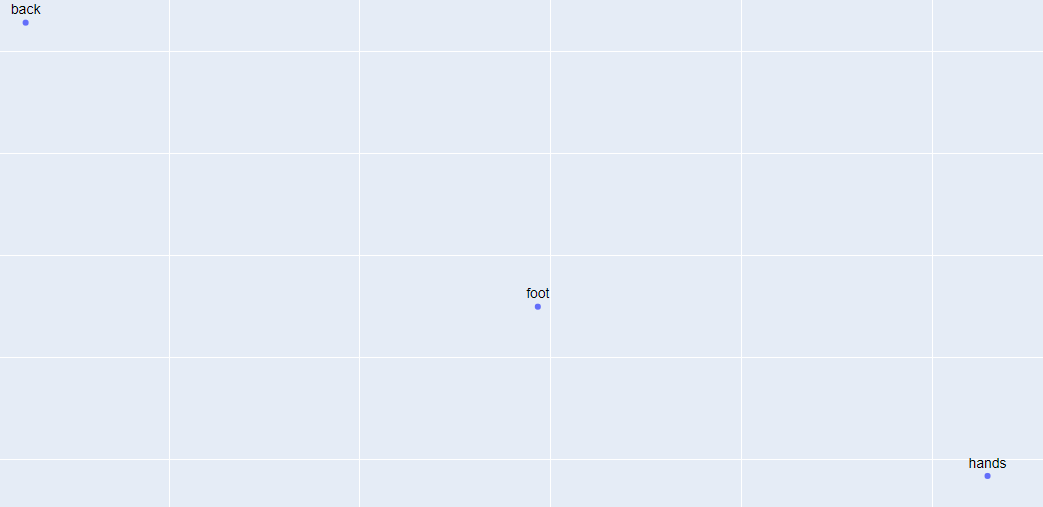

Body parts

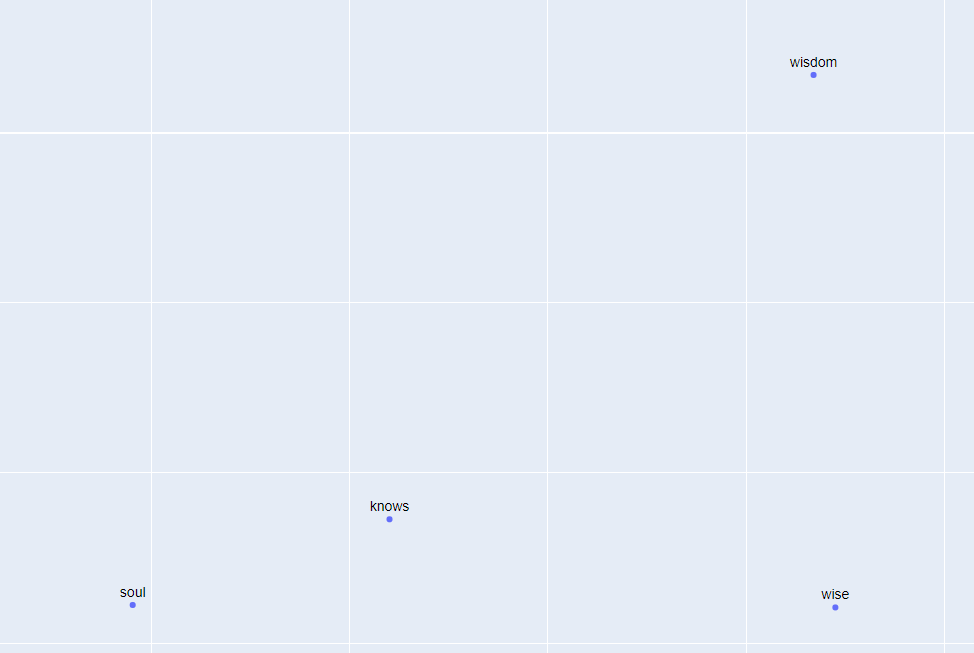

Widsom, knowledge, etc.

3. Based on your inspection of the results, come up with two analogies from the Austen model using 'man' and 'woman' as the A and C terms of the analogy. Describe your results.

In [36]:
complete_analogy(model_JA, 'man','died','woman', 2)

term       sim
0  engaged  0.994442
1    weeks  0.991667

In [37]:
complete_analogy(model_JA, 'man','be','woman', 2)

term       sim
0    give  0.927249
1  giving  0.919008

Man is to "died" as woman is to "arrived" or "fixed" and Man is to "be" as woman is to "prevent" or "give". This seems to imply a relationship in which women are fixing things or arriving as men die. Similarly, men "are" while women "prevent" and "give".

4. Do the same thing with Melville.

In [38]:
complete_analogy(model_HM, 'man','died','woman', 2)

term       sim
0   entered  0.965487
1  remained  0.962788

In [39]:
complete_analogy(model_HM, 'man','be','woman', 2)

term       sim
0    knew  0.902163
1  manner  0.897921

Somewhat less agency for women? For example "man" is to "be" as "woman" is to "self" and "forced"

5. Consider the information that topic models provide in comparison to what word embeddings provide. How would you describe their differences? Might they complementary to each other?

The key difference between word embeddings and topic models is that word embeddings are used to capture the semantic use of words, while topic models are generally used to find themes within a document. They can complement each other by providing different information. Topics from a topic model can give an inuitive sense of themes discussed in a document. These can be complemented with word embeddings, which provide an understand of the semantic use of words.